In [ ]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import glob
from PIL import Image as im 

# Image Mosaicing

In [ ]:
sift = cv2.SIFT_create()

function      <font color=blue>__find_homography__</font>


 -  **Task** : Given source points and destnation points. It finds the homogrphy matrix
 -  **Working**: Takes the source points and destination points. Construct G matrix using the formula
    $ [[X1_i, Y1_i, 1, 0, 0, 0, -X1_i*X2_i, -Y1_i*X2_i, -X2_i] $
    $ [0, 0, 0, X1_i, Y1_i, 1, -Y2_i*X1_i, -Y2_i*Y1_i, -Y2_i]] $
    - Using singular value decomposition for the above matrix we get the homography matrix
 -  **Input** : Source_points and destination_points
 -  **Output** : Homogrpahy matrix

In [ ]:
def find_homography(src,dest):
    G = []
    for i in range(len(src)):
        temp = [src[i][0],src[i][1],1,0,0,0,-1*src[i][0]*dest[i][0],-1*src[i][1]*dest[i][0],-1*dest[i][0]]
        temp2 = [0,0,0,src[i][0],src[i][1],1,-1*src[i][0]*dest[i][1],-1*src[i][1]*dest[i][1],-1*dest[i][1]]
        G.append(temp)
        G.append(temp2)


    matrix = np.linalg.svd(G)
    matrix = matrix[-1][-1]
    homography = [matrix[0:3],matrix[3:6],matrix[6:9]]
    homography = homography/homography[-1][-1]
    return homography

function    <font color=blue>__calculate_error__</font>


 -  **Task** : Given source points, destnation points and matrix. It finds the root mean squared error
 -  **Working**: Takes the source points ,destination points and matrix. Calculates root mean square error
 -  **Input** : Source_points ,destination_points and matrix
 -  **Output** : root mean squared error

In [ ]:
def calculate_error(matrix,src,dest):
    
    if(len(src[0])!=3):
        new_column = [[1]]
        new_column = np.repeat(new_column,len(src),axis=0)
        src = np.append(src, new_column, axis=1)
        
    predicted_dest = []
    for i in range(len(src)):
        x = (np.matmul(matrix,src[i].T))
        x = x/x[-1]
        x = x[:2]
        predicted_dest.append(x)
    sum = 0
    for x in range(len(predicted_dest)):
        a = (predicted_dest[x][0]-dest[x][0])**2
        a+= (predicted_dest[x][1]-dest[x][1])**2
        sum += np.sqrt(a)
    return sum

function    <font color=blue>__get_homography__</font>


 -  **Task** : Given source points, destnation points . It gives the best homography matrix
 -  **Working**: Takes the source points ,destination points. Uses RANSAC algorithm and claculates the homogrpahy with less error and returns that. Used find_homograhy() and calculater_error() defined above
     - number of iterations in RANSAC : 10
 -  **Input** : Source_points ,destination_points
 -  **Output** : best homography matrix

In [ ]:
def get_homography(src,dest):
    s=np.seterr(divide='ignore', invalid='ignore')
    min_error = 100000000000
    for i in range(0,100):
        indexes = random.sample(range(0, len(src)), 4)
        total_indices = np.arange(start=0, stop=len(src), step=1)
        
        src1 = src[indexes]
        dest1 = dest[indexes]
        
        H = find_homography(src1,dest1)
        temp = np.delete(total_indices, indexes)
        
        error = calculate_error(H,src[temp],dest[temp])
        if(error<min_error):
            min_error = error
            homography = H
    return homography

In [ ]:
def process_points(m):
    r = []
    for i in range(len(m)):
        r.append(m[i][0].tolist())

    return np.array(r)

function    <font color=blue>__reda_images__</font>


 -  **Task** : Given path of the folder. reads all the images from that
 -  **Working**: Uses glob and reads images using opencv imread() function
 -  **Input** : Path of the folder
 -  **Output** : Images in that folder

In [ ]:
def read_images(path):
    files=glob.glob(path)
    images = []
    for file in files:
        print(file)
        image = cv2.imread(file)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images.append(image)
    return images

## 1.1 Finding matches between two partially overlapping images

In [ ]:
## Reading the images
image1_ = cv2.imread("../images/Image Mosaicing/1_1.jpg")
image2_ = cv2.imread("../images/Image Mosaicing/1_2.jpg")

In [ ]:
## Convert the BGR images to RGB
image1 = cv2.cvtColor(image1_,cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2_,cv2.COLOR_BGR2RGB)

In [ ]:
## Find the keypoints and descriptors
kp1, des1 = sift.detectAndCompute(image1,None)
kp2, des2 = sift.detectAndCompute(image2,None)

In [ ]:
## Finding the matches using FlannBasedMatcher and KNN
FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

match = cv2.FlannBasedMatcher(index_params, search_params)
matches = match.knnMatch(des1,des2,k=2)

print(matches[:10])

[[<DMatch 0x7f10a4403730>, <DMatch 0x7f10d7eb4250>], [<DMatch 0x7f10a43c2310>, <DMatch 0x7f10a43c2630>], [<DMatch 0x7f10a43c2a50>, <DMatch 0x7f10a43c2930>], [<DMatch 0x7f10a43c26d0>, <DMatch 0x7f10a43c2a70>], [<DMatch 0x7f10a43c27b0>, <DMatch 0x7f10a43c2710>], [<DMatch 0x7f10a43c2850>, <DMatch 0x7f10a43c2a10>], [<DMatch 0x7f10a43c29b0>, <DMatch 0x7f10a43c2870>], [<DMatch 0x7f10a43c2610>, <DMatch 0x7f10a43c2790>], [<DMatch 0x7f10a43c2730>, <DMatch 0x7f10a43c2750>], [<DMatch 0x7f10a43c29d0>, <DMatch 0x7f10a43c2970>]]


Let's get the good matches from the matches we found above

In [ ]:
## Extract only good matches from them
good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append(m)
    
print(good[:10])

[<DMatch 0x7f1093f10770>, <DMatch 0x7f1093f107b0>, <DMatch 0x7f1093f27330>, <DMatch 0x7f1093f3b7b0>, <DMatch 0x7f1093ec5830>, <DMatch 0x7f1093edb8b0>, <DMatch 0x7f1093e4a0f0>, <DMatch 0x7f1093e4fcb0>, <DMatch 0x7f1093e5ecb0>, <DMatch 0x7f1093e660f0>]


## 1.2 Finding the homography matrix of the above the two images

In [ ]:
## Get the points and find homography of the images
src_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)

s = process_points(src_pts)
d = process_points(dst_pts)

H = get_homography(s,d)
print(H)

[[ 5.82722717e-01 -5.54107283e-03  1.50854024e+03]
 [-1.06039941e-01  8.43147535e-01  2.15598744e+02]
 [-9.03871718e-05 -4.90434790e-06  1.00000000e+00]]


## 1.3 Transforming one image to other using homography matrix

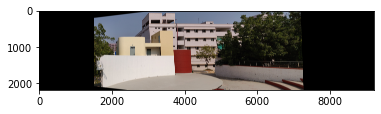

In [ ]:
## Using warpPerspective to transform one image to other's reference frame
dst = cv2.warpPerspective(image2,H,(image1.shape[1]+image2.shape[1], max(image1.shape[0],image2.shape[0])))

plt.imshow(dst)
plt.savefig('../images/results/1_1.3.jpg')
plt.show()

## 1.4 Stiching two images

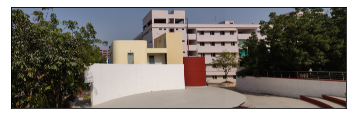

<Figure size 7200x7200 with 0 Axes>

In [ ]:
## Stiching two images

dst = cv2.warpPerspective(image2,H,(image1.shape[1]+image2.shape[1], max(image1.shape[0],image2.shape[0])))
dst[0:image1.shape[0],0:image1.shape[1]] = image1

pixels = image1.shape[1]+image2.shape[1]-1
for i in range(image1.shape[1]+image2.shape[1]-1, 0 ,-1):
    pixel = (dst[4,i,:]==(0,0,0))
    if pixel[0] and pixel[1] and pixel[2]:
        pixels-=1
    else:
        break

dst = dst[:,:pixels+1,:]


plt.imshow(dst)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(100,100))
plt.savefig('../images/results/1_1.4.jpg')
plt.show()

## 1.5 Stiching multiple images

function    <font color=blue>__stich_images__</font>


 -  **Task** : Stiches multiple images
 -  **Working**: Given a set of images it will stich 2 images at a time and uses the result of previous iteration as 1st image and present image as second and continue the loop. If the images ha sto be stiched horizontally it takse vertical=False else vertical=True
 -  **Input** : Set of images and boolean value to know if the stiching has to be horizontal or vertical
 -  **Output** : Stiched image

In [ ]:
def stich_images(images,vertical=False):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    match = cv2.FlannBasedMatcher(index_params, search_params)


    image1 = images[0]
    for i in range(1,len(images)):
        image2 = images[i]
        kp1, des1 = sift.detectAndCompute(image1,None)
        kp2, des2 = sift.detectAndCompute(image2,None)

        matches = match.knnMatch(des1,des2,k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        src_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)

        s = process_points(src_pts)
        d = process_points(dst_pts)
        M = get_homography(s,d)

        if(not vertical):
            dst = cv2.warpPerspective(image2,M,(image1.shape[1]+image2.shape[1], (image1.shape[0])))
        else:
            dst = cv2.warpPerspective(image2,M,(image1.shape[1], (image2.shape[0]+image1.shape[0])))
        dst[0:image1.shape[0],0:image1.shape[1]] = image1
        image1 = dst
        
    return image1

In [ ]:
def remove_black_pixels(img):
    pixels = img.shape[1]-1
    for i in range(img.shape[1]-1, 0 ,-1):
        pixel = (img[4,i,:]==(0,0,0))
        if pixel[0] and pixel[1] and pixel[2]:
            pixels-=1
        else:
            break

    return img[:,:pixels+1,:]

function    <font color=blue>__remove_pixels__</font>


 -  **Task** : Removes black pixels at the end of the image
 -  **Working**: Takes the image and removes the vertical lines at th end if there are majority of black pixels in the line
 -  **Input** : Image
 -  **Output** : Image after removing black pixels at the end

In [ ]:
def remove_pixels(image):
    p = (np.sum(image,axis=0))
    q = np.sum(p,axis=1)

    s = 0

    for i in range(len(q)-1,-1,-1):
        if(q[i]<=40*3*image.shape[0]):
            s+=1
        else:
            break
    
    image = image[:,:image.shape[1]-s,:]
    return image

function    <font color=blue>__remove_vpixels__</font>


 -  **Task** : Removes black pixels at the bottom of the image
 -  **Working**: Takes the image and removes the horizontal lines at the bottom if there are majority of black pixels in the line
 -  **Input** : image
 -  **Output** : image without black pixels at the bottom

In [ ]:
def remove_vpixels(image):
    p = (np.sum(image,axis=1))
    q = np.sum(p,axis=1)

    s = 0

    for i in range(len(q)-1,-1,-1):
        if(q[i]<=40*3*image.shape[1]):
            s+=1
        else:
            break
            
    return image[:image.shape[0]-s,:]

- First stich 1_1 and 1_2 say image
- There are black pixels at the end remove them using remove_black_pixels() function defined above
- Now stich the image and 1_3
- Remove black pixels
- To get the final result stich the image with 1_4 and reomve black pixels

In [ ]:
s = "../images/Image Mosaicing/1_*.jpg"
images = read_images(s)
image = stich_images([images[0],images[1]])    
image = remove_black_pixels(image)
image = stich_images([image,images[2]])
image = remove_black_pixels(image)

../images/Image Mosaicing/1_1.jpg
../images/Image Mosaicing/1_2.jpg
../images/Image Mosaicing/1_3.jpg
../images/Image Mosaicing/1_4.jpg


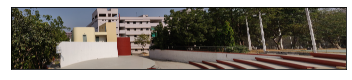

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(10,10))
plt.savefig('../images/results/1_set1.jpg')
plt.show()

## 1.6 Stiching different scenes

In [ ]:
s = "../images/Image Mosaicing/2_*.png"
images = read_images(s)
# # # print(images)
image1 = stich_images([images[3],images[4]]) 

../images/Image Mosaicing/2_4.png
../images/Image Mosaicing/2_5.png
../images/Image Mosaicing/2_6.png
../images/Image Mosaicing/2_1.png
../images/Image Mosaicing/2_2.png
../images/Image Mosaicing/2_3.png


- In this set of images it is observed that 1,2,3 should be stiched horizontally
- And 4,5,6 should be stiched vertically
- Result of both should be stiched vertically
- The smae process is followed below

In [ ]:
image1 = remove_pixels(image1)
image1 = stich_images([image1,images[5]])
image1 = remove_pixels(image1)

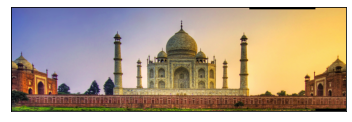

In [ ]:
## Result of stiching 1,2,3
plt.imshow(image1)
plt.xticks([])
plt.yticks([])
plt.show()

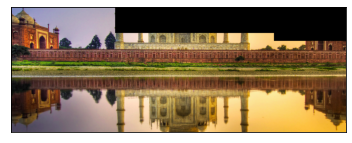

In [ ]:
# result of stiching 4,5,6
image2 = stich_images([images[0],images[1]]) 
image2 = remove_pixels(image2)
image2 = stich_images([image2,images[2]])
image2 = remove_pixels(image2)
plt.imshow(image2)
plt.xticks([])
plt.yticks([])
plt.show()

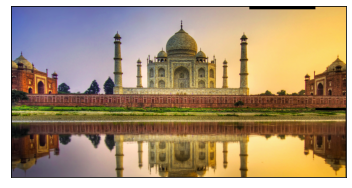

<Figure size 7200x7200 with 0 Axes>

In [ ]:
## Result of stiching both vertically
image2 = stich_images([image1,image2],True)
image2 = remove_vpixels(image2)
plt.imshow(image2)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(100,100))
plt.savefig('../images/results/1_set2.jpg')
plt.show()

../images/Image Mosaicing/3_1.png
../images/Image Mosaicing/3_2.png


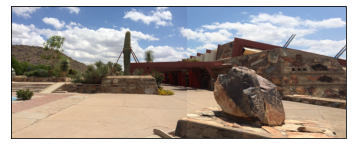

<Figure size 7200x7200 with 0 Axes>

In [ ]:
## Directly stich the two images in the given order we get the output
s = "../images/Image Mosaicing/3_*.png"
images = read_images(s)
image = stich_images(images)
image = remove_black_pixels(image)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(100,100))
plt.savefig('../images/results/1_set3.jpg')
plt.show()

../images/Image Mosaicing/4_2.jpg
../images/Image Mosaicing/4_1.jpg


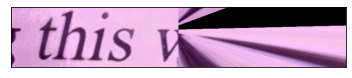

<Figure size 7200x7200 with 0 Axes>

In [ ]:
s = "../images/Image Mosaicing/4_*.jpg"
images = read_images(s)
image = stich_images([images[1],images[0]])
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(100,100))
plt.savefig('../images/results/1_set4.jpg')
plt.show()

##### Observation:

Here this pair of images are not stiched perfectly because there is very less part of images which are overlapping which results in less matches. Hence images can't be stiched perfectly

In [ ]:
s = "../images/Image Mosaicing/5_*.jpg"
images = read_images(s)

../images/Image Mosaicing/5_4.jpg
../images/Image Mosaicing/5_2.jpg
../images/Image Mosaicing/5_1.jpg
../images/Image Mosaicing/5_3.jpg


In [ ]:
x = stich_images([images[2],images[1]])
y = stich_images([images[0],images[3]])

In this set
- Stich 1,2 images horizontally
- Stich 3,4 images horizontally
- Stich results of the above vertically to get the final results

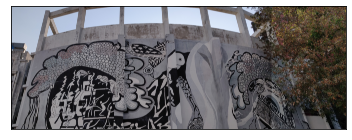

In [ ]:
x = remove_pixels(x)
plt.imshow(x)
plt.xticks([])
plt.yticks([])
plt.show()

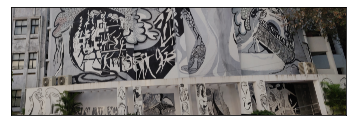

In [ ]:
y = remove_pixels(y)
plt.imshow(y)
plt.xticks([])
plt.yticks([])
plt.show()

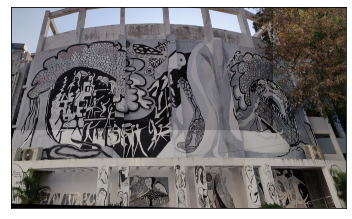

<Figure size 7200x7200 with 0 Axes>

In [ ]:
y = stich_images([x,y],True)
y = remove_pixels(y)
y = remove_vpixels(y)
plt.imshow(y)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(100,100))
plt.savefig('../images/results/1_set5.jpg')
plt.show()